In [32]:
import sys
from pathlib import Path
sys.path.append("../")

import geopandas as gpd
from matplotlib import pyplot as plt
import numpy as np
from shapely import box, Point

from urbanopt import UrbanOPT

# Creating input data
Here we just create some toy input data. There are two types of development opportunity: 
1. `big`: a 10m x 10m square
2. `small`: a 7m x 7m square

We've made it so there are lots of overlaps. 

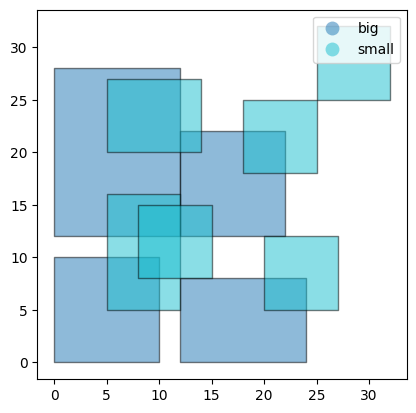

In [33]:
# Parameters
n_big = 4
n_small = 6

geoms = [
    # --- BIG BUILDINGS ---
    box(0, 0, 10, 10),   
    box(12, 0, 24, 8),  
    box(0, 12, 12, 28),   
    box(12, 12, 22, 22),  

    # --- SMALL BUILDINGS ---
    box(5, 5, 12, 16),     
    box(8, 8, 15, 15),      
    box(20, 5, 27, 12),     
    box(5, 20, 14, 27),     
    box(25, 25, 32, 32),   
    box(18, 18, 25, 25)     
]
data = {
    "pid": list(range(1, 11)),
    "label": ["big"] * n_big + ["small"] * n_small,
    "start": ["small"] * n_big + ["empty_site"] * n_small,
    "end": ["big"] * n_big + ["small"] * n_small,
    "desc": ["A big development"] * n_big + ["A small development"] * n_small,
    "geometry": geoms
}

gdf = gpd.GeoDataFrame(data, crs="EPSG:3857")

gdf.plot(
    column="label",
    edgecolor="black",  # Adds the border
    linewidth=1,        # Adjusts border thickness
    alpha=0.5,          # Transparency (0 is clear, 1 is opaque)
    legend=True
)

plt.savefig(
    "development_opportunities.png",
    dpi=300,
    bbox_inches="tight",
    pad_inches=0.05
)

## Costs
Our gdf is missing cost columns and a contribution column. The cost columns can be economic, social, environmental, whatever. We will create two columns: 

`cost_dollar`

This reprents the construction cost of the developments. We assign every big development a random cost between  \\$1000 and \\$1200 per square meter, and every small development a random cost between \\$700 and \\$1000 per square meter.

`cost_bus`

This is a measure of spatial accessibility, and is simply the distance between the nearest edge of every development opportunity and a bus stop at (30,5).

In [34]:
# Dollar cost

big_mask = gdf["label"] == "big"
small_mask = gdf["label"] == "small"
np.random.seed(2026)

# Generate random factors for all rows
gdf.loc[big_mask, "cost_dollars"] = (
    gdf.loc[big_mask, "geometry"].area * np.random.uniform(1000, 1200, size=n_big)
)

gdf.loc[small_mask, "cost_dollars"] = (
    gdf.loc[small_mask, "geometry"].area * np.random.uniform(700, 1000, size=n_small)
)

# Round to 2 decimal places for currency
gdf["cost_dollars"] = gdf["cost_dollars"].round(2)

In [35]:
# Distance to bus stop
bus_stop = Point((30,5))
gdf["cost_bus"] = gdf["geometry"].distance(bus_stop)

## Contribution

This represents what the development opportunities *add* to the region, which will usually mean the number of new housing units, or the number of people housed.

We are going to assume 1 person every 20 sqm. Which is very squishy... but it's just an example :)

In [36]:
gdf["contribution"] = (gdf["geometry"].area / 20).round(0)

In [37]:
opportunities = gdf
opportunities

,pid,label,start,end,desc,geometry,cost_dollars,cost_bus,contribution
0,1,big,small,big,A big development,"POLYGON ((10 0, 10 10, 0 10, 0 0, 10 0))",104386.91,20.000000,5.0
1,2,big,small,big,A big development,"POLYGON ((24 0, 24 8, 12 8, 12 0, 24 0))",103929.83,6.000000,5.0
2,3,big,small,big,A big development,"POLYGON ((12 12, 12 28, 0 28, 0 12, 12 12))",229502.80,19.313208,10.0
3,4,big,small,big,A big development,"POLYGON ((22 12, 22 22, 12 22, 12 12, 22 12))",101777.98,10.630146,5.0
4,5,small,empty_site,small,A small development,"POLYGON ((12 5, 12 16, 5 16, 5 5, 12 5))",64971.60,18.000000,4.0
5,6,small,empty_site,small,A small development,"POLYGON ((15 8, 15 15, 8 15, 8 8, 15 8))",48816.99,15.297059,2.0
6,7,small,empty_site,small,A small development,"POLYGON ((27 5, 27 12, 20 12, 20 5, 27 5))",37212.67,3.000000,2.0
7,8,small,empty_site,small,A small development,"POLYGON ((14 20, 14 27, 5 27, 5 20, 14 20))",61331.42,21.931712,3.0
8,9,small,empty_site,small,A small development,"POLYGON ((32 25, 32 32, 25 32, 25 25, 32 25))",42506.28,20.000000,2.0
9,10,small,empty_site,small,A small development,"POLYGON ((25 18, 25 25, 18 25, 18 18, 25 18))",45813.47,13.928388,2.0


# Single Objective Optimization

Here we construct a very simple example: *minimize the cost (in dollars) while still adding enough housing for 20 people*

In [49]:
#Construct the optimizer and initialize the variables
opt = UrbanOPT(opportunities)
opt.build_variables()

In [50]:
# For a single objective
w = {"cost_dollars": 1.0}
opt.set_objective(weights=w)

In [51]:
# We must add housing for at least 20 people
opt.add_contribution_constraints(
    limits = 20,
    sense = ">=",
    boundaries = None, # default,the entire region
    tag = "min_pop_increase",
);

In [52]:
# Check the status of the model
opt.debug_model(verbose=True)

Gurobi Model Debug Info
- Variables: 10
- Constraints: 1
- Objective set: True
- Model status: 1

Objective Weights:
  cost_dollars: 1.0

Variables (first 20):
  x_1: not solved
  x_2: not solved
  x_3: not solved
  x_4: not solved
  x_5: not solved
  x_6: not solved
  x_7: not solved
  x_8: not solved
  x_9: not solved
  x_10: not solved

Constraint Tags:
  [min_pop_increase] 1 constraints


In [55]:
opt.solve()

Optimization Summary
  Objective Value   : 396211.83
  Total Contribution: 20.00
  Solve Time        : 0.005 sec
  Selected Pathways : 6


Selected opportunities: [2, 4, 5, 7, 9, 10]


<Axes: >

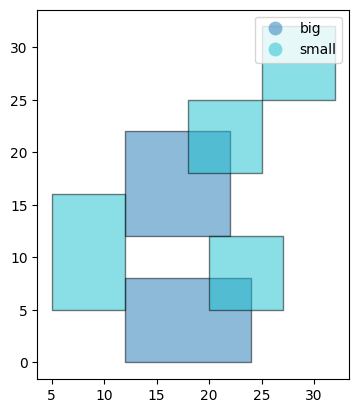

In [57]:
print("Selected opportunities:", opt.get_selected_pids())

filtered = opportunities[opportunities.pid.isin(opt.get_selected_pids())]
filtered.plot(
    column="label",
    edgecolor="black",  # Adds the border
    linewidth=1,        # Adjusts border thickness
    alpha=0.5,          # Transparency (0 is clear, 1 is opaque)
    legend=True
)

There is clearly a problem here, our development sites overlap! We can add some additional constraints to fix this.

In [58]:
# Ensure opportunities don't overlap
opt.add_mutual_exclusion_constraints(
    label1 = "small",
    label2 = None, # Default, We can specify this if we only want to exclude overlaps with a single label type
    tag = "no_intersect_small",
)

opt.add_mutual_exclusion_constraints(
    label1 = "big",
    tag = "no_intersect_big",
);

In [59]:
opt.solve()

Optimization Summary
  Objective Value   : 435210.61
  Total Contribution: 20.00
  Solve Time        : 0.000 sec
  Selected Pathways : 3


Selected opportunities: [2, 3, 4]


<Axes: >

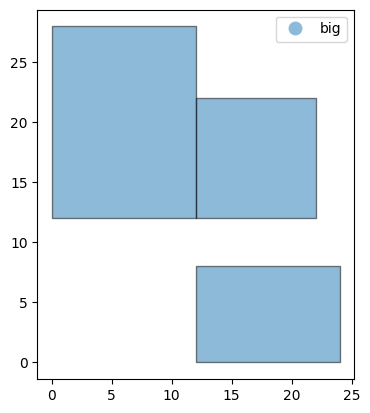

In [60]:
print("Selected opportunities:", opt.get_selected_pids())

filtered = opportunities[opportunities.pid.isin(opt.get_selected_pids())]
filtered.plot(
    column="label",
    edgecolor="black",  # Adds the border
    linewidth=1,        # Adjusts border thickness
    alpha=0.5,          # Transparency (0 is clear, 1 is opaque)
    legend=True
)